# DES Forward model

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
from LSS_forward_model.theory import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import BaryonForge as bfn
import frogress

In [55]:
from LSS_forward_model.theory import LimberTheory

# Setup forward model - config

In [85]:
type_ = 'SGC'

# Setup     ********************************
path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Fiducial/11_big/'
#path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/derivatives//runsdom_m2/run001/'

# general settings ----------------------------------
nside_maps = 1024

# nuisance parameters ------------------------------
m_NGC = np.array([-0.92,-1.9,4.0,-3.73])*0.01
m_SGC = np.array([-1.33,-2.26,-3.67,-5.72])*0.01
m_DES = np.array([-0.00343755,  0.0064513 ,  0.01591432,  0.00162992])
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0]
if type_ =='NGC':
    nuisance_parameters['dm'] = np.array( [1,1,1,1]) + m_NGC
elif type_ =='SGC':
    nuisance_parameters['dm'] = np.array( [1,1,1,1]) + m_SGC
elif type_ =='DES':
    nuisance_parameters['dm'] = np.array( [1,1,1,1]) + m_DES

nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1]
nuisance_parameters['rot'] = 0


# Baryonification settings ------------------------------------------------

baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1.5,
    "mass_cut": 13,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_wl_tsz_flamingo_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}
'''

baryons = {
        "enabled": True,
        "max_z_halo_catalog": 1,
        "mass_cut": 13.2,
        "do_tSZ": True,
        "base_params_path": "../Data/Baryonification_default_parameters.npy",
        "filename_new_params": "sys_baryo_0.npy"}
'''
baryon_priors =   {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")}   
baryons[ "values_to_update"] = draw_params_from_specs(baryon_priors)
            
bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)
#sims_parameters.update(sys)

if type_ =='DES':
    SC_corrections = np.load('../Data/SC_DES.npy',allow_pickle =True).item()
elif type_ =='NGC':
    SC_corrections = np.load('../Data/SC_NGC.npy',allow_pickle =True).item()
elif type_ =='SGC':
    SC_corrections = np.load('../Data/SC_SGC.npy',allow_pickle =True).item()

 

# Read cosmology & setup params

In [86]:
# get basic info --------------------
sims_parameters, cosmo_bundle = read_sims_params(path_simulation)
sims_parameters.update(nuisance_parameters)

# baryons - 
bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)
sims_parameters.update(sys)

# recover shells info (edges, redshift, etc)
shells_info = recover_shell_info(path_simulation+'/z_values.txt', max_z=49)

# Setup n(z)

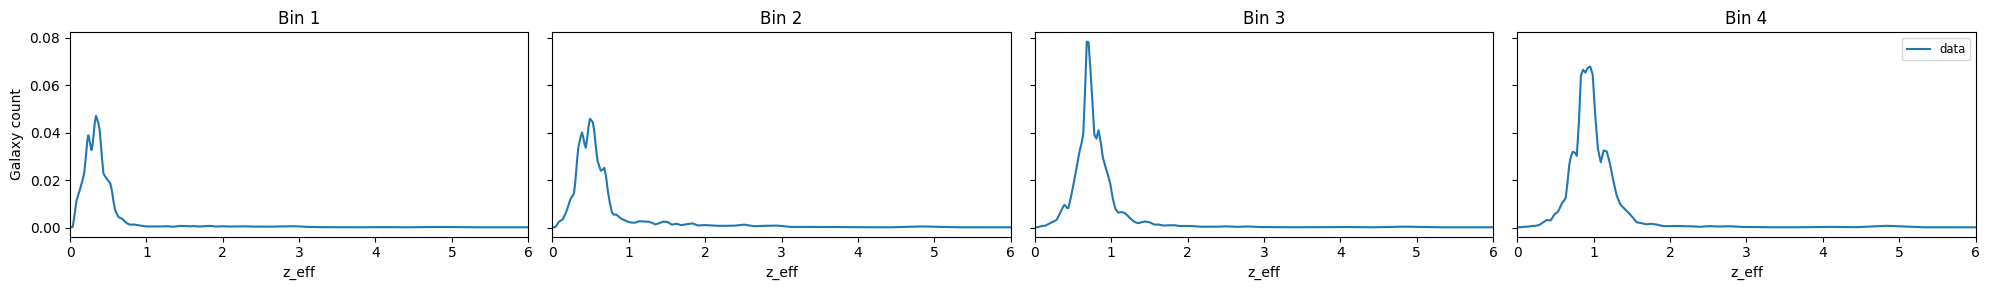

In [87]:
if type_ == 'NGC':
    nz_RR2 = np.load('/global/cfs/cdirs/m5099/DESY3/nz_NGC.npy',allow_pickle=True).item()
elif type_ == 'SGC':
    nz_RR2 = np.load('/global/cfs/cdirs/m5099/DESY3/nz_SGC.npy',allow_pickle=True).item()
elif type_ == 'DES':
    nz_RR2 = np.load('/global/cfs/cdirs/m5099/DESY3/nz_DESY6.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)

# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
titles = [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff_glass, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()


# Compute density/kappa (with or without baryonification)

In [8]:
# density field ---------------------
density, label_baryonification = load_and_baryonify_gower_st_shells(
    path_simulation,
    sims_parameters,
    cosmo_bundle,
    baryons,
    nside_maps,
    shells_info,
    shells)

# shear field ---------------------------
fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density

100.0% | [##########] | Progress: 100 / 100 | Time: 1min4s | ETA: --           

# Theory checks

using euclid emu
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes beyond k_max = 9.41h/Mpc. 
Higher k modes constantly extrapolated.
EuclidEmulator2 emulates the non-linear correction in 
the interval [8.73e-3 h/Mpc, 9.41h/Mpc]. You are 
requesting k modes below k_min = 8.73e-3 h/Mpc. 
Lower k modes constantly extrapolated.
100.0% | [##########] | Progress: 4000 / 4000 | Time: 6.4s | ETA: --           

/tmp/ipykernel_332942/290356946.py:22: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


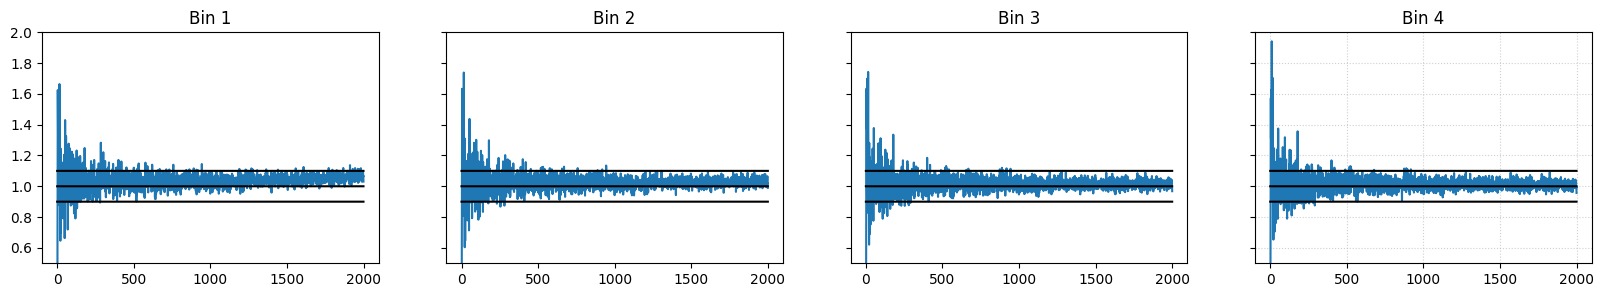

In [88]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="euclidemu")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)


kappa_tomo = integrate_field(ngal_glass, fields["kappa"])

Cls = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])



# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 4, figsize=(20, 3), sharey=True)
titles = [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


# make realistic maps with source clustering

In [89]:
if type_ == 'NGC':
    path_data_cats ='/global/cfs/cdirs/m5099/DESY3/DECADE_NGC.npy'
elif type_ == 'SGC':
    path_data_cats='/global/cfs/cdirs/m5099/DESY3/DECADE_SGC.npy'
elif type_ == 'DES':
    path_data_cats='/global/cfs/cdirs/m5099/DESY3/DESY6.npy'

cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()
maps_Gower_WL,_ = make_WL_sample(ngal_glass, zeff_glass, cosmo_bundle, sims_parameters, nside_maps, fields, cats_Euclid, SC_corrections = SC_corrections, do_catalog = False, include_SC = True)

# Compute some summary statistics data & mocks

In [90]:
# make maps 
maps_data = dict()
for t in cats_Euclid.keys():
    pix_ = convert_to_pix_coord(cats_Euclid[t]['ra'],cats_Euclid[t]['dec'], nside=1024)
    unique_pix, idx, idx_rep = np.unique(pix_, return_index=True, return_inverse=True)
    
    n_map = np.zeros(hp.nside2npix(1024))
    e1_map = np.zeros(hp.nside2npix(1024))
    e2_map = np.zeros(hp.nside2npix(1024))
    e1n_map = np.zeros(hp.nside2npix(1024))
    e2n_map = np.zeros(hp.nside2npix(1024))
    
    n_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[t]['w'])
    mask = n_map != 0
    e1_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[t]['e1']*cats_Euclid[t]['w'])
    e2_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[t]['e2']*cats_Euclid[t]['w'])
    e1_map[mask]  = e1_map[mask]/(n_map[mask])
    e2_map[mask] =  e2_map[mask]/(n_map[mask])


    es1,es2 = apply_random_rotation(cats_Euclid[t]['e1'], cats_Euclid[t]['e2'])

    e1n_map[unique_pix] += np.bincount(idx_rep, weights=es1*cats_Euclid[t]['w'])
    e2n_map[unique_pix] += np.bincount(idx_rep, weights=es2*cats_Euclid[t]['w'])
    e1n_map[mask]  = e1n_map[mask]/(n_map[mask])
    e2n_map[mask] =  e2n_map[mask]/(n_map[mask])

    
    E,B,_ ,_ = g2k_sphere(e1_map,-e2_map,mask = mask,nside=1024, lmax=2048) # There's a sign flip in the DES data!! that's OK it's just catalog convetions !!!!
    E[~mask] = 0.
    B[~mask] = 0.

    EN,BN,_ ,_ = g2k_sphere(e1n_map,-e2n_map,mask = mask,nside=1024, lmax=2048) # There's a sign flip in the DES data!! that's OK it's just catalog convetions !!!!
    EN[~mask] = 0.
    BN[~mask] = 0.
    
    maps_data[t] = {'e1':e1_map,'e2':e2_map,'E':E,'B':B,'EN':EN,'BN':BN}


for t in cats_Euclid.keys():
    mask = maps_Gower_WL[t]['g1_map'] != 0
    E,B,_ ,_ = g2k_sphere(maps_Gower_WL[t]['e1'],maps_Gower_WL[t]['e2'],mask = mask, nside=1024, lmax=2048)
    E[~mask] = 0.
    B[~mask] = 0.
    maps_Gower_WL[t]['E'] = E
    maps_Gower_WL[t]['B'] = B
    E,B,_ ,_ = g2k_sphere(maps_Gower_WL[t]['e1n'],maps_Gower_WL[t]['e2n'],mask = mask, nside=1024, lmax=2048)
    E[~mask] = 0.
    B[~mask] = 0.
    maps_Gower_WL[t]['EN'] = E
    maps_Gower_WL[t]['BN'] = B


In [ ]:
# Initialize dictionaries
mom_gower_dict = {}
mom_data_dict = {}
mom_gower_dictB = {}
mom_data_dictB = {}

scales = [3,6,12,24,48,96]

sm_maps_E_sims = np.array([np.array([(hp.smoothing(maps_Gower_WL[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower_WL.keys()])
sm_maps_E_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['E'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_data.keys()])

sm_maps_EN_sims = np.array([np.array([(hp.smoothing(maps_Gower_WL[tomo]['EN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower_WL.keys()])
sm_maps_EN_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['EN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_data.keys()])

sm_maps_B_sims = np.array([np.array([(hp.smoothing(maps_Gower_WL[tomo]['B'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower_WL.keys()])
sm_maps_B_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['B'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_data.keys()])

sm_maps_BN_sims = np.array([np.array([(hp.smoothing(maps_Gower_WL[tomo]['BN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_Gower_WL.keys()])
sm_maps_BN_data = np.array([np.array([(hp.smoothing(maps_data[tomo]['BN'], fwhm=np.radians(sm/60))) for sm in scales]) for tomo in maps_data.keys()])


In [ ]:
import matplotlib.pyplot as plt
import healpy as hp

vmin, vmax = -0.01, 0.01
j = 5  # the second index you were using

plt.figure(figsize=(18, 7))

for i in range(4):  # tomo bins 0..3
    # --- Data row ---
    hp.mollview(
        sm_maps_E_data[i][j],
        min=vmin, max=vmax,
        title=f"Data  (tomo {i})  |  smooth=100 arcmin",
        sub=(2, 4, 1 + i),
        cbar=False
    )

    # --- Sims row ---
    hp.mollview(
        sm_maps_E_sims[i][j],
        min=vmin, max=vmax,
        title=f"Sims  (tomo {i})  |  smooth=100 arcmin",
        sub=(2, 4, 5 + i),
        cbar=False
    )

# One colorbar (optional): easiest is to just enable it for the last panel
# If you want a single shared colorbar, healpy doesn't do it elegantly; simplest is:
#hp.mollview(sm_maps_E_sims[3][j], min=vmin, max=vmax, sub=(2,4,8), title="", cbar=True)

plt.suptitle("E-mode maps, Mollweide full-sky view", y=0.98, fontsize=14)
plt.tight_layout()
plt.show()


In [83]:
mom_gower_dict[2]  = dict()
mom_gower_dict[3]  = dict()
mom_data_dict[2]  = dict()
mom_data_dict[3]  = dict()

ntomo = 4
# Loop through tomographic bins
for i in range(ntomo):
    for j in range(ntomo):
        if i >= j:
            mom_gower_dict[2][(i,j)] = np.mean(sm_maps_E_sims[i]*sm_maps_E_sims[j],axis=1) - np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j],axis=1)
            mom_data_dict[2][(i,j)] =np.mean(sm_maps_E_data[i]*sm_maps_E_data[j],axis=1) - np.mean(sm_maps_EN_data[i]*sm_maps_EN_data[j],axis=1)


for i in range(ntomo):
    for j in range(ntomo):
        for k in range(ntomo):
            mom_gower_dict[3][(i,j,k)] = np.mean(sm_maps_E_sims[i]*sm_maps_E_sims[j]*sm_maps_E_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_data_dict[3][(i,j,k)]  = np.mean(sm_maps_E_data[i]*sm_maps_E_data[j]*sm_maps_E_data[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 





mom_gower_dictB[2]  = dict()
mom_gower_dictB[3]  = dict()
mom_data_dictB[2]  = dict()
mom_data_dictB[3]  = dict()

ntomo = 4
# Loop through tomographic bins
for i in range(ntomo):
    for j in range(ntomo):
        if i >= j:
            mom_gower_dictB[2][(i,j)] = np.mean(sm_maps_B_sims[i]*sm_maps_B_sims[j],axis=1) - np.mean(sm_maps_BN_sims[i]*sm_maps_BN_sims[j],axis=1)
            mom_data_dictB[2][(i,j)] =np.mean(sm_maps_B_data[i]*sm_maps_B_data[j],axis=1)   - np.mean(sm_maps_BN_data[i]*sm_maps_BN_data[j],axis=1) 


for i in range(ntomo):
    for j in range(ntomo):
        for k in range(ntomo):
            mom_gower_dictB[3][(i,j,k)] = np.mean(sm_maps_B_sims[i]*sm_maps_B_sims[j]*sm_maps_B_sims[k],axis=1) #- np.mean(sm_maps_EN_sims[i]*sm_maps_EN_sims[j]) 
            mom_data_dictB[3][(i,j,k)]  = np.mean(sm_maps_B_data[i]*sm_maps_B_data[j]*sm_maps_B_data[k],axis=1)# - np.mean(sm_maps_EN_nosc_sims[i]*sm_maps_EN_nosc_sims[j]) 


In [ ]:
fig, axes = plt.subplots(
    1, 4, figsize=(10, 2.8),
    sharex=True, sharey=True
)

for i in range(4):
    j = i
    ax = axes[i]

    # zero reference
    ax.axhline(0, color='0.7', lw=1, zorder=0)

    # BB
    ax.plot(
        scales,
        mom_data_dictB[2][(i, j)] * np.array(scales),
        color='tab:blue',
        lw=2,
        label='BB (data)' if i == 0 else None
    )
    ax.plot(
        scales,
        mom_gower_dictB[2][(i, j)] * np.array(scales),
        color='tab:blue',
        lw=2,
        ls='--',
        label='BB (sims)' if i == 0 else None
    )

    ax.set_xscale('log')
    ax.set_title(rf'Tomo {i}×{i}', fontsize=11)
    ax.set_xlabel(r'$\theta$ [arcmin]')

    if i == 0:
        ax.set_ylabel(r'$\theta\,\langle \kappa^2\rangle$')

    ax.tick_params(labelsize=9)

# shared legend
fig.legend(
    loc='upper center',
    ncol=2,
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, 1.05)
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




fig, axes = plt.subplots(
    1, 4, figsize=(10, 2.8),
    sharex=True, sharey=True
)

for i in range(4):
    j = i
    ax = axes[i]

    # zero reference
    ax.axhline(0, color='0.7', lw=1, zorder=0)

    # BB
    ax.plot(
        scales,
        mom_data_dict[2][(i, j)] * np.array(scales),
        color='tab:blue',
        lw=2,
        label='EE (data)' if i == 0 else None
    )
    ax.plot(
        scales,
        mom_gower_dict[2][(i, j)] * np.array(scales),
        color='tab:blue',
        lw=2,
        ls='--',
        label='EE (sims)' if i == 0 else None
    )

    ax.set_xscale('log')
    ax.set_title(rf'Tomo {i}×{i}', fontsize=11)
    ax.set_xlabel(r'$\theta$ [arcmin]')

    if i == 0:
        ax.set_ylabel(r'$\theta\,\langle \kappa^2\rangle$')

    ax.tick_params(labelsize=9)

# shared legend
fig.legend(
    loc='upper center',
    ncol=2,
    frameon=False,
    fontsize=10,
    bbox_to_anchor=(0.5, 1.05)
)

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:

fig, axes = plt.subplots(1, 4, figsize=(12, 2.5), sharex=True, sharey=True)

i = 6
for i in range(7):
    ax = axes[i]
    ax.plot(np.array(scales), 0*mom_gower_dict[2][(i, i)] * np.array(scales), color = 'grey')
    ax.plot(np.array(scales), mom_gower_dict[2][(i, i)] * np.array(scales), label='EE (data)',color = 'red')
    ax.plot(np.array(scales), mom_data_dict[2][(i, i)] * np.array(scales), label='EE (sims)',color = 'red', linestyle = 'dashed')
    
    ax.set_xscale('log')
    ax.set_title(f'{i}{i}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if i == 0:
        ax.set_ylabel(r'$\theta \, \langle \kappa^2\rangle$')



In [ ]:



'''

fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 6
for i in range(7):
    ax = axes[i]
    ax.plot(np.array(scales), 0*mom_gower_dict[2][(i, i)] * np.array(scales), color = 'grey')
    ax.plot(np.array(scales), mom_gower_dict[2][(i, i)] * np.array(scales), label='EE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_dict[2][(i, i)] * np.array(scales), label='EE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{i}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if i == 0:
        ax.set_ylabel(r'$\theta \, \langle \kappa^2\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()

fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 0
for j in range(7):
    ax = axes[j]
    ax.plot(np.array(scales), 0*mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, color = 'grey')
    ax.plot(np.array(scales), mom_gower_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (data)',color = c_4)
    ax.plot(np.array(scales), mom_gower_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (data)',color = c_2)

    ax.plot(np.array(scales), mom_data_noise_sc[3][(i, j, j)] * np.array(scales)**2, label='ENN (sims)',color = c_4, linestyle = 'dashed')
    ax.plot(np.array(scales), mom_data_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims)',color = c_2, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{j}{j}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if j == 0:
        ax.set_ylabel(r'$\theta^2 \, \langle \kappa^3\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


fig, axes = plt.subplots(1, 7, figsize=(12, 2.5), sharex=True, sharey=True)

i = 4
for j in range(7):
    ax = axes[j]
    ax.plot(np.array(scales), 0*mom_data_dict[3][(i, j, j)] * np.array(scales)**2, color = 'grey')
    ax.plot(np.array(scales), mom_data_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (data)',color = c_2)

    ax.plot(np.array(scales), mom_gower_dict[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims)',color = c_2, linestyle = 'dashed')
    ax.plot(np.array(scales), mom_gower_dict_noSC[3][(i, j, j)] * np.array(scales)**2, label='EEE (sims no SC)',color = c_4, linestyle = 'dashed')
    ax.set_xscale('log')
    ax.set_title(f'{i}{j}{j}')
    ax.set_xlabel(r'$\theta$ [arcmin]')
    if j == 0:
        ax.set_ylabel(r'$\theta^2 \, \langle \kappa^3\rangle$')


axes[3].legend(loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.5))

    
# Reduce horizontal space between subplots
plt.subplots_adjust(wspace=0.05)

#plt.tight_layout()
plt.show()


# Tests

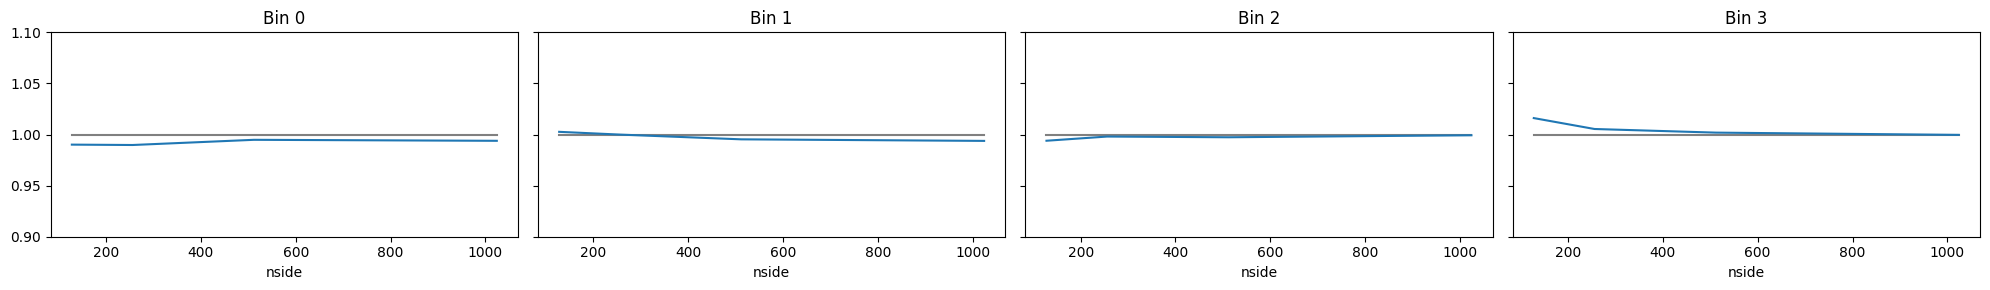

In [72]:
# Check dependence with scale
mask_sims = maps_Gower_WL[0]['g1_map'] !=0 

nns = [1024,512,256,128]
ee_coeff = dict()
for tomo in maps_Gower_WL:
    ee_coeff[tomo] = np.zeros(len(nns))
for i,nside_out in enumerate(nns):
    for tomo in maps_Gower_WL:
        
        A = (hp.ud_grade(maps_Gower_WL[tomo]['e1n'],nside_out = nside_out)**2+hp.ud_grade(maps_Gower_WL[tomo]['e2n'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
        B = (hp.ud_grade(maps_Gower_WL[tomo]['e1r_map0_ref'],nside_out = nside_out)**2+hp.ud_grade(maps_Gower_WL[tomo]['e2r_map0_ref'],nside_out = nside_out)**2)[hp.ud_grade(mask_sims,nside_out=nside_out)]
        ee_coeff[tomo][i] =  (np.sqrt(np.mean(A)/np.mean(B)))


fig, axes = plt.subplots(1, 4, figsize=(20, 3), sharey=True)

for tomo in range(4):
    ax = axes[tomo]
    ax.plot(nns,np.ones(len(nns)),color = 'grey')
    ax.plot(nns,ee_coeff[tomo]**2)
    ax.set_title(f'Bin {tomo}' if i > 0 else 'Non-tomo')
    ax.set_xlabel("nside")
    ax.set_ylim([0.9,1.1])
plt.tight_layout()
plt.show()


# Determine SC coefficients

In [14]:
bbb = [0.5,0.6,0.7,0.8,0.9,1.,1.1,1.2,1.3,1.4,1.5]

n_tomo = 4
calib = dict()
for bbb_ in bbb:
    # if you need to do SC calibration use these ----------
    bias_sc = bbb_*np.ones(n_tomo)
    corr_variance_array = np.ones(n_tomo)
    coeff_kurtosis_array = np.zeros(n_tomo)
    A_corr_array  = np.ones(n_tomo)

    
    
    kappa_tot  = np.zeros((n_tomo,12*nside_maps**2))
    g1_tot  =    np.zeros((n_tomo,12*nside_maps**2))
    g2_tot  =    np.zeros((n_tomo,12*nside_maps**2))
    d_tot  =     np.zeros((n_tomo, 12*nside_maps**2))
    
    
    # load each lightcone output in turn and add it to the simulation
    # note: I added a -sign to gamma to match data conventions later
    for tomo in range(n_tomo):
        for i in (range(len(fields['kappa']))):       
            kappa_tot[tomo] += ngal_glass[tomo,i] * fields['kappa'][i][0].real * (1 + bias_sc[tomo] * fields['density'][i])
            g1_tot[tomo] += ngal_glass[tomo,i] * (-fields['gamma'][i][0].real) * (1 + bias_sc[tomo] * fields['density'][i])
            g2_tot[tomo] += ngal_glass[tomo,i] * (-fields['gamma'][i][0].imag) * (1 + bias_sc[tomo] * fields['density'][i])
            d_tot[tomo]  += ngal_glass[tomo,i] * (1 + bias_sc[tomo] * fields['density'][i] )
       
    
    
    cats_Gower = dict()
    maps_Gower = dict()
    for tomo in range(n_tomo):
        maps_Gower[tomo] = dict()
    
        pix = convert_to_pix_coord(cats_Euclid[tomo]['ra'],cats_Euclid[tomo]['dec'], nside=nside_maps)
        
        # source clustering term ~
        f = 1./np.sqrt(d_tot[tomo])
        f = f[pix]
    
    
        n_map = np.zeros(hp.nside2npix(nside_maps))
        n_map_sc = np.zeros(hp.nside2npix(nside_maps))
    
                        
        unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    
    
        n_map_sc[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w']/f**2)
        n_map[unique_pix] += np.bincount(idx_rep, weights=cats_Euclid[tomo]['w'])
    
        g1_ = g1_tot[tomo][pix]
        g2_ = g2_tot[tomo][pix]
    
    
        es1,es2 = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)
        es1_ref,es2_ref = apply_random_rotation(cats_Euclid[tomo]['e1'], cats_Euclid[tomo]['e2'])
        es1a,es2a = apply_random_rotation(cats_Euclid[tomo]['e1']/f, cats_Euclid[tomo]['e2']/f)
    
    
        #x1_sc,x2_sc = addSourceEllipticity({'shear1':g1_,'shear2':g2_},{'e1':es1,'e2':es2},es_colnames=("e1","e2"))
    
    
        e1r_map = np.zeros(hp.nside2npix (nside_maps))
        e2r_map = np.zeros(hp.nside2npix (nside_maps))
        e1r_map0 = np.zeros(hp.nside2npix(nside_maps))
        e2r_map0 = np.zeros(hp.nside2npix(nside_maps))
        e1r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
        e2r_map0_ref = np.zeros(hp.nside2npix(nside_maps))
        g1_map = np.zeros(hp.nside2npix(nside_maps))
        g2_map = np.zeros(hp.nside2npix(nside_maps))
    
        unique_pix, idx, idx_rep = np.unique(pix, return_index=True, return_inverse=True)
    
    
        e1r_map[unique_pix] += np.bincount(idx_rep, weights=es1*cats_Euclid[tomo]['w'])
        e2r_map[unique_pix] += np.bincount(idx_rep, weights=es2*cats_Euclid[tomo]['w'])
    
        e1r_map0[unique_pix] += np.bincount(idx_rep, weights=es1a*cats_Euclid[tomo]['w'])
        e2r_map0[unique_pix] += np.bincount(idx_rep, weights=es2a*cats_Euclid[tomo]['w'])
    
        e1r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es1_ref*cats_Euclid[tomo]['w'])
        e2r_map0_ref[unique_pix] += np.bincount(idx_rep, weights=es2_ref*cats_Euclid[tomo]['w'])
    
    
        mask_sims = n_map_sc != 0.
        e1r_map[mask_sims]  = e1r_map[mask_sims]/(n_map_sc[mask_sims])
        e2r_map[mask_sims] =  e2r_map[mask_sims]/(n_map_sc[mask_sims])
        e1r_map0[mask_sims]  = e1r_map0[mask_sims]/(n_map_sc[mask_sims])
        e2r_map0[mask_sims] =  e2r_map0[mask_sims]/(n_map_sc[mask_sims])
        e1r_map0_ref[mask_sims]  = e1r_map0_ref[mask_sims]/(n_map[mask_sims])
        e2r_map0_ref[mask_sims] =  e2r_map0_ref[mask_sims]/(n_map[mask_sims])
    
    
    
        var_ =  e1r_map0_ref**2+e2r_map0_ref**2
    
    
        #'''
        e1r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
        e2r_map   *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
        e1r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
        e2r_map0  *= 1/(np.sqrt(A_corr_array[tomo]*corr_variance_array[tomo])) * np.sqrt((1+coeff_kurtosis_array[tomo]*var_))
    
    
    
        
        
        #'''
        g1_map[unique_pix] += np.bincount(idx_rep, weights= g1_*cats_Euclid[tomo]['w'])
        g2_map[unique_pix] += np.bincount(idx_rep, weights= g2_*cats_Euclid[tomo]['w'])
    
    
    
        g1_map[mask_sims]  = g1_map[mask_sims]/(n_map_sc[mask_sims])
        g2_map[mask_sims] =  g2_map[mask_sims]/(n_map_sc[mask_sims])
    
        e1_ = ((g1_map+e1r_map0))#[mask_sims]
        e2_ = ((g2_map+e2r_map0))#[mask_sims]
        e1n_ = ( e1r_map)#[mask_sims]
        e2n_ = ( e2r_map)#[mask_sims]
       # idx_ = np.arange(len(mask_sims))[mask_sims]
    
        maps_Gower[tomo] =     {'g1_map':g1_map,'g2_map':g2_map,'e1':e1_,'e2':e2_,'e1n':e1n_,'e2n':e2n_,
                                'e1r_map0_ref':e1r_map0_ref,
                                'e2r_map0_ref':e2r_map0_ref,
                                'var_':var_}


    from scipy.optimize import minimize
    
    new_corr_variance_array = []
    new_coeff_kurtosis_array = []
    new_A_corr_array = [] 
    for tomo in range(n_tomo):
        x = copy.deepcopy(maps_Gower[tomo]['e1n'][mask_sims]**2 + maps_Gower[tomo]['e2n'][mask_sims]**2)
        y = copy.deepcopy(maps_Gower[tomo]['e1r_map0_ref'][mask_sims]**2 + maps_Gower[tomo]['e2r_map0_ref'][mask_sims]**2)
        
        mean_y = np.mean(y)
        mean_y2 = np.mean(y**2)
        
        corr_var = (((np.mean(x)/np.mean(y))))
        

        f = 1/corr_var

        
        
        def objective(params):
            coeff_kurtosis, A = params
            corr_var = (np.mean(x) / mean_y)
            f = 1 / (A * corr_var) * (1 + coeff_kurtosis * x)
            var_ratio = np.mean(x * f) / mean_y
            kurt_ratio = np.mean((x * f)**2) / mean_y2
            return (var_ratio - 1)**2 + (kurt_ratio - 1)**2
        # initial guess: small kurtosis correction and A ~ 1
        initial = [0.01, 0.995]
        
        # optional: bounds to keep params in physical range
        bounds = [(-1, 1), (0.9, 1.1)]
        
        res = minimize(objective, initial, bounds=bounds)
        
        coeff_kurtosis_opt, A_opt = res.x
        print(f"Optimized coeff_kurtosis = {coeff_kurtosis_opt:.6f}, A = {A_opt:.6f}")
        
        # Check results
        f_opt = 1 / (A_opt * corr_var) * (1 + coeff_kurtosis_opt * x)
        
        
        new_corr_variance_array.append(corr_var)
        new_coeff_kurtosis_array.append(coeff_kurtosis_opt)
        new_A_corr_array.append(A_opt)


    calib[bbb_] = [new_corr_variance_array,new_coeff_kurtosis_array,new_A_corr_array]

Optimized coeff_kurtosis = -0.036588, A = 0.998287
Optimized coeff_kurtosis = -0.022740, A = 0.998834
Optimized coeff_kurtosis = -0.029369, A = 0.998508
Optimized coeff_kurtosis = -0.009184, A = 0.999299
Optimized coeff_kurtosis = -0.029720, A = 0.998597
Optimized coeff_kurtosis = -0.022628, A = 0.998835
Optimized coeff_kurtosis = -0.019959, A = 0.998986
Optimized coeff_kurtosis = -0.018158, A = 0.998618
Optimized coeff_kurtosis = -0.067372, A = 0.996767
Optimized coeff_kurtosis = -0.031516, A = 0.998359
Optimized coeff_kurtosis = -0.036640, A = 0.998133
Optimized coeff_kurtosis = -0.010621, A = 0.999188
Optimized coeff_kurtosis = -0.061921, A = 0.997021
Optimized coeff_kurtosis = -0.055778, A = 0.997082
Optimized coeff_kurtosis = -0.039556, A = 0.997974
Optimized coeff_kurtosis = -0.009364, A = 0.999284
Optimized coeff_kurtosis = -0.071706, A = 0.996509
Optimized coeff_kurtosis = -0.075635, A = 0.996018
Optimized coeff_kurtosis = -0.033182, A = 0.998290
Optimized coeff_kurtosis = -0.0

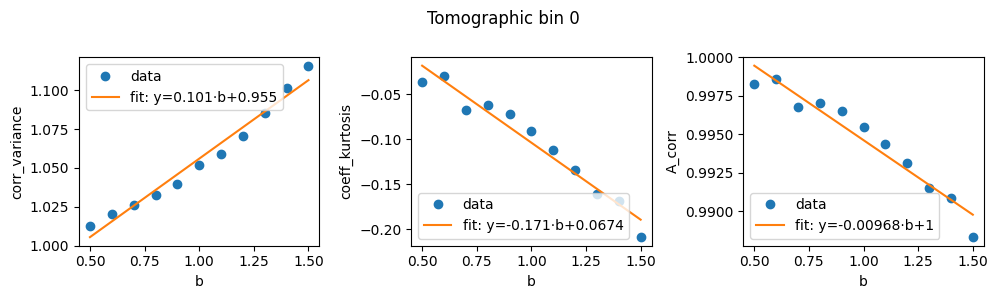

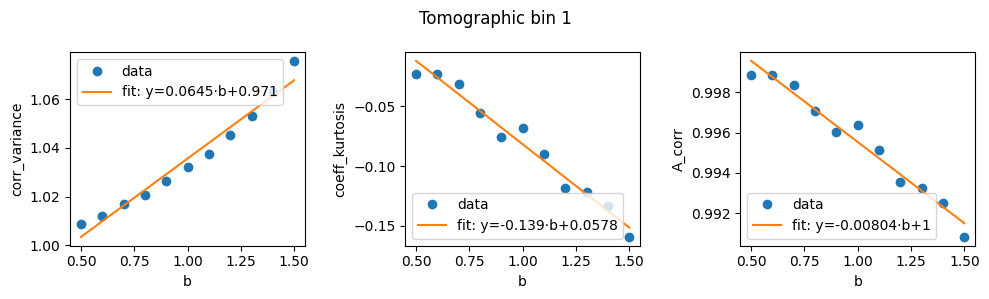

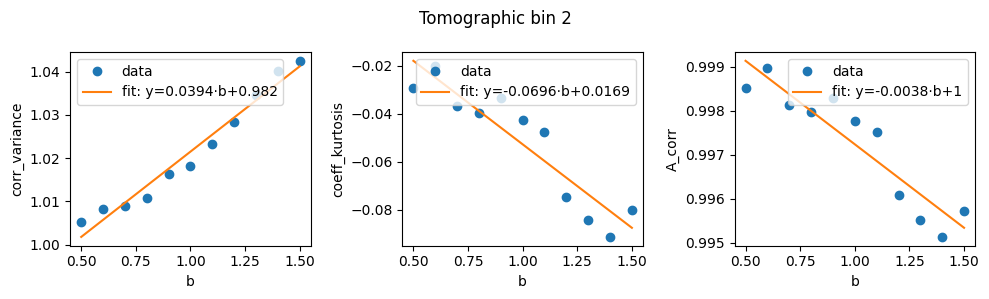

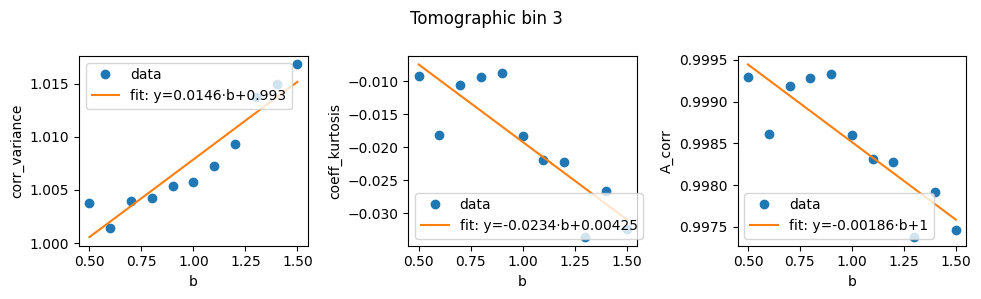

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Reusable containers: after running, each entry is a callable f(b) = m*b + q
corr_variance_fit = []
coeff_kurtosis_fit = []
A_corr_fit = []

def _fit_linear(x, y):
    """Return (poly1d, slope, intercept)."""
    mask = np.array(y) ==  np.array(y)
    m, q = np.polyfit(np.asarray(x[mask]), np.asarray(y[mask]), 1)
    return np.poly1d([m, q]), m, q

def plot_and_fit_tomo(tomo, bbb, calib, show=True):
    """
    For one tomo index:
      - collects y(b) for the three quantities,
      - fits y = m*b + q,
      - plots 3 panels,
      - returns the three poly1d callables (f_corr, f_kurt, f_A).
    """
    bbb = np.asarray(bbb)
    y_corr  = np.array([calib[b][0][tomo] for b in bbb])
    y_kurt  = np.array([calib[b][1][tomo] for b in bbb])
    y_Acorr = np.array([calib[b][2][tomo] for b in bbb])

    
    f_corr,  m1, q1 = _fit_linear(bbb, y_corr)
    f_kurt,  m2, q2 = _fit_linear(bbb, y_kurt)
    f_A,     m3, q3 = _fit_linear(bbb, y_Acorr)

    # 3-panel plot
    fig, ax = plt.subplots(1, 3, figsize=(10, 3), sharex=True)
    pads = [0.12, 0.12, 0.12]  # keep margins tidy

    # Panel 1: corr_variance
    ax[0].plot(bbb, y_corr, marker='o', linestyle='none', label='data')
    ax[0].plot(bbb, f_corr(bbb), label=f'fit: y={m1:.3g}·b+{q1:.3g}')
    ax[0].set_xlabel('b'); ax[0].set_ylabel('corr_variance'); ax[0].legend()

    # Panel 2: coeff_kurtosis
    ax[1].plot(bbb, y_kurt, marker='o', linestyle='none', label='data')
    ax[1].plot(bbb, f_kurt(bbb), label=f'fit: y={m2:.3g}·b+{q2:.3g}')
    ax[1].set_xlabel('b'); ax[1].set_ylabel('coeff_kurtosis'); ax[1].legend()

    # Panel 3: A_corr
    ax[2].plot(bbb, y_Acorr, marker='o', linestyle='none', label='data')
    ax[2].plot(bbb, f_A(bbb), label=f'fit: y={m3:.3g}·b+{q3:.3g}')
    ax[2].set_xlabel('b'); ax[2].set_ylabel('A_corr'); ax[2].legend()

    fig.suptitle(f'Tomographic bin {tomo}')
    fig.tight_layout()

    if show:
        plt.show()

    return f_corr, f_kurt, f_A

# ---- main loop over tomographic bins ----
# assumes you already have: nz, bbb, calib
corr_variance_fit = [None] *len(ngal_glass)
coeff_kurtosis_fit = [None] * len(ngal_glass)
A_corr_fit = [None] *len(ngal_glass)

for tomo in range(len(ngal_glass)):
    f1, f2, f3 = plot_and_fit_tomo(tomo, bbb, calib, show=True)
    corr_variance_fit[tomo] = f1
    coeff_kurtosis_fit[tomo] = f2
    A_corr_fit[tomo] = f3

np.save('/global/homes/m/mgatti/LSS_forward_model/Data/SC_{0}.npy'.format(type_),
        {'corr_variance_fit':corr_variance_fit,
        'coeff_kurtosis_fit':coeff_kurtosis_fit,
        'A_corr_fit':A_corr_fit})



# usage_fit ---------------------
#val = corr_variance_fit[tomo](b0)

# CMB lensing

In [28]:
for i in range(1,201):

    nuisance_parameters = dict()
    nuisance_parameters['dz'] =  [0,0,0,0]
    baryons = { "enabled": False,
        "max_z_halo_catalog": 1.5,
        "mass_cut": 13,
        "do_tSZ": False,
        "base_params_path": "../Data/Baryonification_wl_tsz_flamingo_parameters.npy",
        "filename_new_params": "sys_baryo_0.npy",
        "values_to_update":  None} # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
    


    path_simulation = '/global/cfs/cdirs/m5099/GowerSt2/Fiducial/{0}_big/'.format(i)
    nside_maps = 1024

    # get basic info --------------------
    sims_parameters, cosmo_bundle = read_sims_params(path_simulation)
    sims_parameters.update(nuisance_parameters)
    
    # baryons - 
    bpar, sys = load_or_save_updated_params(path_simulation,baryons['base_params_path'],baryons['filename_new_params'],baryons['values_to_update'], overwrite = False)
    sims_parameters.update(sys)
    
    # recover shells info (edges, redshift, etc)
    shells_info = recover_shell_info(path_simulation+'/z_values.txt', max_z=49)


    nz_RR2 = np.load('/global/cfs/cdirs/m5099/DESY3/nz_DESY6.npy',allow_pickle=True).item()
    
    # -------------------------------------------------------
    nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
        z_rebinned=nz_RR2['z_rebinned'],
        nz_all=nz_RR2['nz_rebinned'],
        dz_values=sims_parameters["dz"],
        shells_info=shells_info,
    )


    density, label_baryonification = load_and_baryonify_gower_st_shells(
        path_simulation,
        sims_parameters,
        cosmo_bundle,
        baryons,
        nside_maps,
        shells_info,
        shells)


    theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="euclidemu")  # "euclidemu" | "mead" | "halofit"
    theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)


    cmb_map, diag, meta = cmb_lensing_from_glass_plus_gaussian(
        zeff_glass=zeff_glass,
        density=density,
        shells=shells,
        theory=theory,
        cosmo_bundle=cosmo_bundle,
        nside_maps=nside_maps,
        z_max_born=3.5,
        seed=0,
    )
    np.save(path_simulation+'cmb_lensing.npy',{'cmb_map':cmb_map, 'diagnostics_z_max':diag, 'meta':meta})

using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid emu
using euclid e

In [ ]:
1